# Выбор локации для скважины

Проект для компании «ГлавРосГосНефть». Поставлена задача выбора месторождения для разработки новых скважин. В нашем распоряжении данные о пробах нефти в трех регионах - качество нефти и объем ее запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Для выбора оптимальной локации используют следующий алгоритм:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель проекта:** изучить имеющиеся данные, построить модели машинного обучения для каждого региона, посчитать прибыль, и, оценив риски, выбрать лучший регион для разработок.

Ход выполнения проекта: данные получены благодаря геологоразведке и хранятся в трех файлах: `/datasets/geo_data_0.csv`, `/datasets/geo_data_1.csv`, `/datasets/geo_data_2.csv`. О качестве данных ничего известно, поэтому возможно потребуется предобработка прежде чем можно будет приступить к построению моделей. Изучим данные, построим модели, оценим их качество по метрике RMSE, расчитаем необходимые статистические параметры и выберем оптимальный регион. Таким образом исследование прйодет в несколько этапов:

- Загрузка данных
- Подготовка данных
- Обучение и оценка качества моделей
- Подготовка к расчету прибыли
- Расчет прибыли и оценка рисков
- Выбор лучшего меторождения

## Загрузка и подготовка данных

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None 

### Загрузка данных

In [2]:
df1 = pd.read_csv('datasets/geo_data_0.csv')
df2 = pd.read_csv('datasets/geo_data_1.csv')
df3 = pd.read_csv('datasets/geo_data_2.csv')

### Обзор данных

Посмотрим общую информацию по имеющимся данным

In [3]:
df_list = [df1, df2, df3]

In [4]:
display(df1.head(), df2.head(), df3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
for df in df_list:
    df.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-N

Мы имеем 3 различных датасета с 5 колонками и 10000 записями в каждом. Пропуски в данных отсутствуют. Согласно полученной документации: 

**Параметры**
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

**Целевой признак**
* `product` — объём запасов в скважине (тыс. баррелей).

Посмтрим общую статистическую информацию по датасетам

In [6]:
for df in df_list:
    display(df.describe())
    print('\n')

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Уже на этом этапе можно обратить внимание на то, что среднее и медианное значение целевого признака выше в первом и третьем месторождении, возможно это скажется и на итоговых результатах.

Поскольку предстоит использовать линейную регрессию выведем графики с информацией о корреляциях в данных.

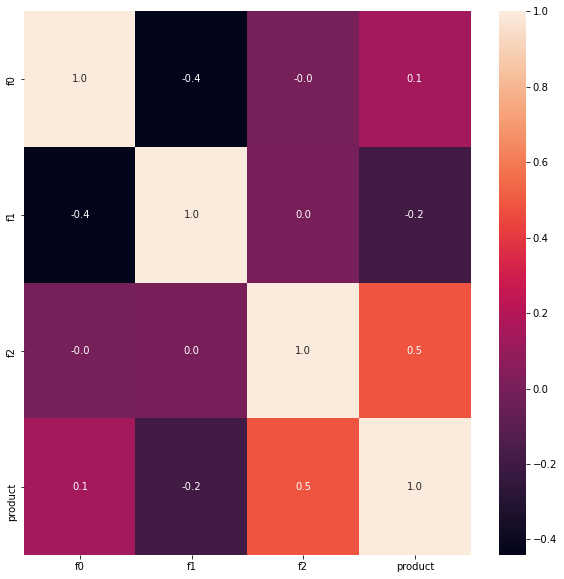

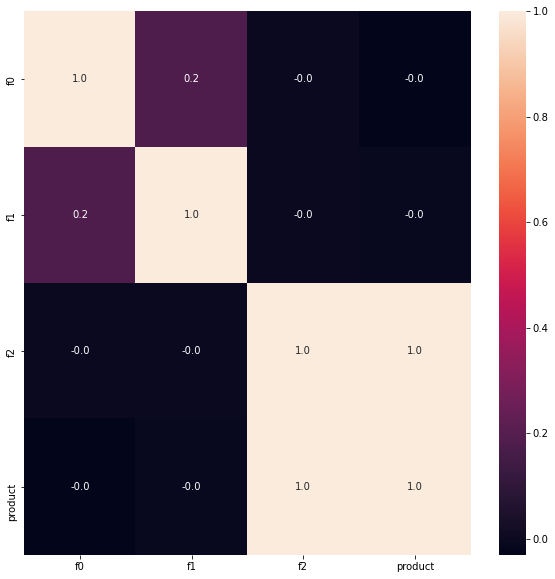

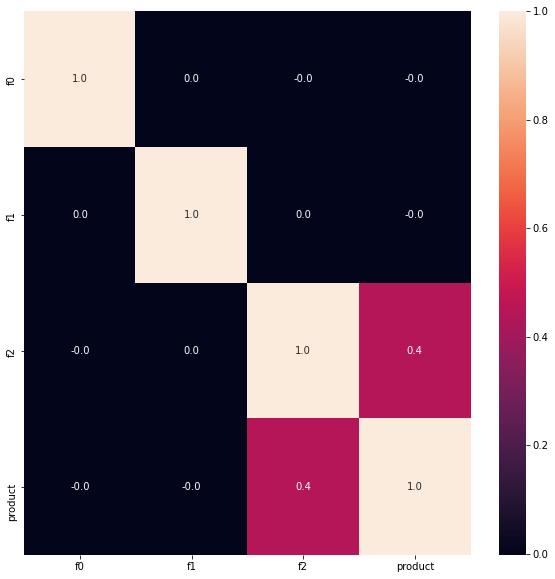

In [7]:
for df in df_list:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df.corr(), annot=True, fmt='.1f')

Во втором месторождении присутствует сильная корреляция между параметром **f2** и целевым признаком, возможно на этом датасете модель покажет лучшие результаты, если использовать только этот параметр для обучения. В двух других месторождениях сильная корреляция не наблюдается. Так как мы используем линейную модель, то вероятно, что модель, обученная на датасете второго месторождения будет работать точнее.

## Обучение и проверка модели

### Разделение данных на выборки

Разделим имеющиеся датасеты на обучающую и валидационную выборку в отношении 75:25

**Первое месторождение**

In [8]:
features_first =  df1.drop(['product'], axis=1)
target_first = df1['product']

In [9]:
features_train_first, features_valid_first, target_train_first, target_valid_first = train_test_split(features_first,
                                                                                                     target_first,
                                                                                                     random_state=1,
                                                                                                     test_size=.25)

**Второе месторождение**

In [10]:
features_scnd =  df2.drop(['product'], axis=1)
target_scnd = df2['product']

In [11]:
features_train_scnd, features_valid_scnd, target_train_scnd, target_valid_scnd = train_test_split(features_scnd,
                                                                                                     target_scnd,
                                                                                                     random_state=1,
                                                                                                     test_size=.25)

**Третье месторождение**

In [12]:
features_thrd =  df3.drop(['product'], axis=1)
target_thrd = df3['product']

In [13]:
features_train_thrd, features_valid_thrd, target_train_thrd, target_valid_thrd = train_test_split(features_thrd,
                                                                                                     target_thrd,
                                                                                                     random_state=1,
                                                                                                     test_size=.25)

Посмотрим на размеры получившихся выборок

In [14]:
print(features_train_first.shape[0], features_train_scnd.shape[0], features_train_thrd.shape[0])

75000 75000 75000


In [15]:
print(features_valid_first.shape[0], features_valid_scnd.shape[0], features_valid_thrd.shape[0])

25000 25000 25000


In [16]:
print(target_train_first.shape[0], target_train_scnd.shape[0], target_train_thrd.shape[0])

75000 75000 75000


In [17]:
print(target_valid_first.shape[0], target_valid_scnd.shape[0], target_valid_thrd.shape[0])

25000 25000 25000


### Обучение моделей

Подготовим шаблон для автоматизации обучения моделей

In [18]:
stages = []
values_1 = (features_train_first, features_valid_first, target_train_first, target_valid_first)
values_2 = (features_train_scnd, features_valid_scnd, target_train_scnd, target_valid_scnd)
values_3 = (features_train_thrd, features_valid_thrd, target_train_thrd, target_valid_thrd)
for i, stage in enumerate([values_1, values_2, values_3]):
    model = LinearRegression()
    model.fit(stage[0][['f0', 'f1', 'f2']], stage[2])
    predictions = model.predict(stage[1][['f0', 'f1', 'f2']])
    stage[1][['product_true']] = stage[3]
    stage[1][['product_predicted']] = predictions
    print('Месторождение', i+1)
    display(stage[1].head())
    print()
    rmse = mean_squared_error(stage[3], predictions, squared=False)
    mean_value = predictions.mean()
    stages.append({
        "Месторождение": i+1, 
        "RMSE" : rmse,
        "Средний запас сырья" : mean_value
    })  
results = pd.DataFrame(stages)
results

Месторождение 1


,id,f0,f1,f2,product_true,product_predicted
43660,MUOMg,0.951436,0.296027,6.817623,89.929339,122.077150
87278,OZXkj,0.800004,0.231734,-2.650680,94.203721,59.962649
14317,adoVK,0.726819,-0.422117,2.645328,123.553649,103.766210
81932,8rZOO,0.193998,-0.247002,-1.002114,83.166422,75.190233
95321,RyFFq,0.890555,-0.498876,4.448591,146.285652,117.368716



Месторождение 2


,id,f0,f1,f2,product_true,product_predicted
43660,lkoIC,2.365991,7.466907,2.990761,80.859783,81.760894
87278,CUVk0,13.475920,-10.191469,-0.000108,0.000000,-0.087805
14317,A4aSR,9.993776,-15.519432,2.011834,53.906522,54.756918
81932,rkW6y,8.738673,-3.064249,4.003998,107.813044,108.366828
95321,1CUkY,7.917746,1.232051,2.000682,53.906522,54.402051



Месторождение 3


,id,f0,f1,f2,product_true,product_predicted
43660,dCoRV,-0.804419,0.910995,2.886761,102.734478,97.207831
87278,TFdxM,-0.401696,-0.024390,-1.195403,72.411400,73.693815
14317,wV83L,0.101773,-1.699503,1.509664,27.076410,89.225341
81932,sgdPb,-0.972245,1.907999,-3.650935,53.209936,59.603718
95321,xSvzy,-0.183940,0.814632,12.021626,112.650597,149.768631


,Месторождение,RMSE,Средний запас сырья
0,1,37.742587,92.492625
1,2,0.894338,69.120405
2,3,39.866711,94.956830


Средний запас сырья больше всего в месторождении 3, а наименьший в месторождении 2. Точнее всего модель отработала на данных с месторождения 2, как и предполагалось. Модели же на двух других месторождениях отработали со схожей и значительно большей ошибкой.

## Подготовка к расчёту прибыли

Создадим переменные для расчета требуемого запаса сырья для безубыточной разработки

In [19]:
PRICE = 450000 #цена одной тысячи баррелей нефти
BUDGET = 10000000000 #бюджет на разработку скважин
N_POINTS = 200 #кол-во оптимальных точек для разработки

Рассчитаем, какой запас сырья должен быть в выбранных точках, чтобы их разработка была неубыточна

In [20]:
sum_price = 0
count = 0
while sum_price < BUDGET:
    count += 1
    sum_price += PRICE
print(count / N_POINTS)

111.115


Полученное значение равно 111.115 тыс. баррелей, что превышает то среднее, которое получилось у каждого месторождения при предсказании моделей. Стоит заметить, что при оценке среднего использовались асболютно все данные, и вероятно, что, при выборе 200 самых оптимальных скважин, среднее в каждом месторождении увеличится

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли

In [21]:
def profit_calc(data):
    top_200 = data.sort_values(by='product_predicted', ascending=False).head(200)
    # display(top_200)
    sum_cap_first = top_200['product_true'].sum()
    profit = sum_cap_first * PRICE
    # print('Суммарный запас сырья: ', sum_cap_first)
    # print('Прибыль:', round(profit - BUDGET, 0))
    return round(profit - BUDGET, 0)

**200 лучших скважин месторождения 1**

In [22]:
profit_calc(features_valid_first)

3260781418.0

**200 лучших скважин месторождения 2**

In [23]:
profit_calc(features_valid_scnd)

2415086697.0

**200 лучших скважин месторождения 3**

In [24]:
profit_calc(features_valid_thrd)

2563093352.0

Напишем функцию для расчета статистической информации по месторождениям и проверки условий бизнеса

In [25]:
def region_stats(data):
    state = np.random.RandomState(1)
    bootstrap_samples = 1000
    values = []
    for i in range(bootstrap_samples):
        target_subsample = data.sample(n=500, replace=True, random_state=state)
        values.append(profit_calc(target_subsample))
    
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975) 
    mean = values.mean()
    prob_loss = (values[values < 0]).count() / values.shape[0]
    print("Средняя прибыль:", mean)
    print("95% доверительный интервал: [", lower, ':', upper, ']')
    print('Вероятность убытков:', prob_loss)

**Рассчет для первого региона**

In [26]:
region_stats(features_valid_first)

Средняя прибыль: 433009400.231
95% доверительный интервал: [ -100239627.07499999 : 947109532.8249999 ]
Вероятность убытков: 0.052


**Рассчет для второго региона**

In [27]:
region_stats(features_valid_scnd)

Средняя прибыль: 475197242.996
95% доверительный интервал: [ 95175980.275 : 851622360.8499999 ]
Вероятность убытков: 0.01


**Рассчет для третьего региона**

In [28]:
region_stats(features_valid_thrd)

Средняя прибыль: 394751289.06
95% доверительный интервал: [ -157824822.2 : 914050354.925 ]
Вероятность убытков: 0.073


Согласно полученным условиям: **После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.** Данному условию соответствует только второе месторождение, вероятность убытков в нем равна 1%. Именно в этом регионе стоит начинать разработку.

## Выводы

В ходе исследования были проанализированы данные по трем различным месторождениям и получены следующие выводы:

* Лучшим регоном для разработки является второй, вероятность убытков равна 1%
* Самая высокая средняя прибыль во втором регионе
* Самая низкая средняя прибыль в третьем регионе, в нем же и наибольшая вероятность убытков: 7,3%